### INTRODUCTION

* **Dataset** 
The MNIST dataset has  70,000 small square 28×28 pixel grayscale images of handwritten digits between 0 and 9.

* The task is classifying a given image of a handwritten digit as such it will correspond to one of 10 classes, integer values from 0 to 9.

* Keras provides access to the MNIST dataset via the mnist.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.



https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

In [ ]:
# Tensorflow / Keras
from skimage.transform import resize
import numpy
import tensorflow as tf
from tensorflow import keras
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy import vstack
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose
from matplotlib import pyplot
from numpy import expand_dims
from keras import backend
#print('Tensorflow/Keras: %s' % keras.__version__)
from keras.models import Model
from keras.datasets.mnist import load_data

# load the images 
(trainX, trainy), (testX, testy) = load_data()
# The Shape of train and test set
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [ ]:

# convert from unsigned ints to floats
#X = X.astype('float32')
# scale from [0,255] to [0,1]
#X = X / 255.0

## Model 

* The images in the dataset feed the training loop of created Generative Adversarial Network (GAN). The generator model learns how to create new  handwritten digits between 0 and 9, by using a discriminator which distinguishes real images from the dataset and  outputs (new image from the generator model).

### Discriminator Network

* Discrminator  model is a binary classification problem. Image with one channel and with sized of 28x28 in pixels are inputs and whether the sample is real or fake is the output. The written model has two convolution layers with 64 filters, kernel size of 3, stride of 2. it has no pooling layers, and at the end, contains sigmoid activation function. The Loss function is binary cross entropy loss. The other activation function used between layer are LeakyRelu, optimizer is Adam with 0.0001 learning rate, and also dropout regularization teqnique is used between convolutional layers.

* The model architecture is given in below. The 2×2 stride provide down-sample the input image, first from 28×28 to 14×14, and finally 7×7, at that point the discrminator makes an prediction.


### Load Real Samples, Generate Real Samples, Generate Fake Random Samples

* load_real_samples function preapres the input data and generate_real_samples creates the real images from the dataset and generate_fake_samples create randomly created fake sample. Train Discrminator function train the discrminatro and  shows us accuracy results of how the discrminator distinguiseh the reals and fakes.


In [ ]:
# implementation of wasserstein loss
import numpy as np
#def wasserstein_loss(y_true, y_pred):
 #return backend.mean(y_true * y_pred)
def wasserstein_loss(y_true, y_pred):
 return backend.mean(y_true) * backend.mean(y_pred)

In [ ]:
# prepare the inception v3 model
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

Calculate_Fid=True
if Calculate_Fid:
  model_fid = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
  print("FID Calculation Activated")
if Calculate_Fid==False:
  print("FID calculation deactivated.")

FID Calculation Activated


In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
 # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
 # store
        images_list.append(new_image)
    return asarray(images_list)

In [ ]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
 # calculate activations
 act1 = model.predict(images1)
 act2 = model.predict(images2)
 # calculate mean and covariance statistics
 mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
 mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 # calculate sum squared difference between means
 ssdiff = numpy.sum((mu1 - mu2)**2.0)
 # calculate sqrt of product between cov
 covmean = sqrtm(sigma1.dot(sigma2))
 # check and correct imaginary numbers from sqrt
 if iscomplexobj(covmean):
  covmean = covmean.real
 # calculate score
  fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
 return fid

In [ ]:
'''# define the standalone discriminator model
def discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

SyntaxError: ignored

In [ ]:
# define the standalone discriminator model
from keras import backend
def discriminator(in_shape=(28,28,1),wasserstein=False):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    #model.add(Dense(1)) # fow WasserStein
    # compile model
    if wasserstein==True:
      model.compile(loss=wasserstein_loss, optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])
    else:
      model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model

# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_rand_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_rand_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
#model = discriminator()
# load image data
#model.summary()
#dataset = load_real_samples()
# fit the model
#train_discriminator(model, dataset)

### Generator Network

* The generator model creats new and fake but real-like images of handwritten digits. It takes a point from the latens space as input and gives image output(in our case, a square greyscale image.)
* The latent space is a vector space defined randomly and of values with a Gaussian distribution (for instnace, 100 dimension). It makes no sense, but by drawing random points from this space and giving them to the generator model for training, the generator model will assign meaning to that points and so the latent vector space represents a compressed representation of the output space which only generator knows in the sense of generating images.
* Generator model requires transforming a vector from the latent space with, 100 dimensions to a 2D array.
* It involves two main elements. The first is a Dense layer having enough nodes to represent a low-resolution version of the output image. For instance, an image half the size of the image would be 14×14.
* The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image.

* One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose. We will use this latter approach for our generator. The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions).


In [ ]:
# define the standalone generator model
def generator(latent_dim):
 model = Sequential()
 # foundation for 7x7 image
 n_nodes = 128 * 7 * 7
 model.add(Dense(n_nodes, input_dim=latent_dim))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Reshape((7, 7, 128)))
 # upsample to 14x14
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 # upsample to 28x28
 model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
 model.add(LeakyReLU(alpha=0.2))
 model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
 return model
 
# define the size of the latent space
latent_dim = 100
# define the generator model
model = generator(latent_dim)
# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                              

1/1 [==============================] - 2s 2s/step


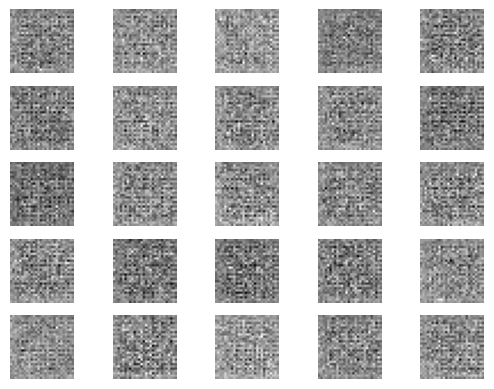

In [ ]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# size of the latent space
latent_dim = 100
# define the discriminator model
model = generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

### GAN and Training

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

In [ ]:
# define the combined generator and discriminator model, for updating the generator
import tensorflow as tf
def GAN(g_model, d_model):
 # make weights in the discriminator not trainable
 d_model.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(g_model)
 # add the discriminator
 model.add(d_model)
 # compile model
 model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001))
 return model
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = GAN(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
#plot_model(gan_model,
           #show_shapes=True, show_layer_names=True)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_2 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d_loss_epoch=[]
    g_loss_epoch=[]
    FID_epoch=[]
    # manually enumerate epochs
    for i in range(n_epochs):
        epoch_d_loss=0
        epoch_g_loss=0
        fid_epoch=0
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            #Calculate FID
            if j==int(dataset.shape[0]/n_batch)-1 and i%10==0 and Calculate_Fid==True: # at the end of the batch and for each 10 epoch
              X_real_fid=scale_images(X_real,(299,299,3))
              X_fake_fid = scale_images(X_fake,(299,299,3))
              fid_batch = calculate_fid(model_fid,X_real_fid,X_fake_fid)
              print("FID VALUE:", fid_batch, "Epoch:",i)
              FID_epoch.append(fid_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            epoch_d_loss += d_loss
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            epoch_g_loss += g_loss
            # summarize loss on this batch
        epoch_d_loss /= bat_per_epo
        epoch_g_loss /= bat_per_epo
        #fid_epoch/=bat_per_epo
        #print("FID VALUE:", fid_epoch)
        print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, epoch_d_loss, epoch_g_loss))
        d_loss_epoch.append(epoch_d_loss)
        g_loss_epoch.append(epoch_g_loss)
        #FID_epoch.append(fid_batch)
    return d_loss_epoch, g_loss_epoch, FID_epoch

In [ ]:
#FID_epoch

In [ ]:
from skimage.transform import resize
import numpy
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = GAN(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
d_loss_epoch, g_loss_epoch,FID_epoch=train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256)

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 3ms/step
>79, 234/234, d=0.689, g=0.707
4/4 [==============================] - 0s 3ms/step
>80, 234/234, d=0.688, g=0.715
4/4 [==============================] - 0s 110ms/step
FID VALUE: 92.49827996863021 Epoch: 80
>81, 234/234, d=0.688, g=0.708
4/4 [==============================] - 0s 3ms/step
>82, 234/234, d=0.686, g=0.717
4/4 [==============================] - 0s 5ms/step
>83, 234/234, d=0.687, g=0.717
4/4 [==============================] - 0s 3ms/step
>84, 234/234, d=0.687, g=0.704
4/4 [==============================] - 0s 3ms/step
>85, 234/234, d=0.689, g=0.711
4/4 [==============================] - 0s 3ms/step
>86, 234/234, d=0.688, g=0.709
4/4 [==============================] - 0s 3ms/step
>87, 234/234, d=0.688, g=0.705
4/4 [==============================] - 0s 3ms/step
>88, 234/234, d=0.687, g=0.707
4/4 [==============================] - 0s 4ms/step
>89, 234/234, d=0.688, g=0.713
4/4 [=

## Show Loss Values

<Axes: xlabel='Epoch', ylabel='G and D Loss'>

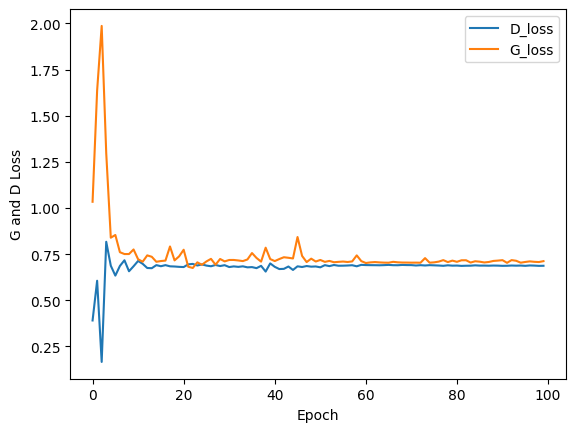

<Figure size 1000x600 with 0 Axes>

In [ ]:
#import pandas as pd
#epochs=[i for i in range(len(d_loss_epoch))]
#loss_frame = pd.DataFrame({"D_loss":d_loss_epoch,"G_loss":g_loss_epoch}) #Epoch":epochs
#d_loss_epoch, g_loss_epoch
#loss_frame.plot(xlabel="Epoch",ylabel="G and D Loss")
#pyplot.savefig("plot_loss")
import matplotlib.pyplot as plt
import pandas as pd
def plot_loss(d_loss_epoch,g_loss_epoch,epochs=100):
  loss_frame = pd.DataFrame({"D_loss":d_loss_epoch,"G_loss":g_loss_epoch})
  plot = loss_frame.plot(xlabel="Epoch",ylabel="G and D Loss")
  plt.figure(figsize=(10, 6))
  plt.savefig("plot_loss_Gan_Final")
  return plot
plot_loss(d_loss_epoch,g_loss_epoch,epochs=100)

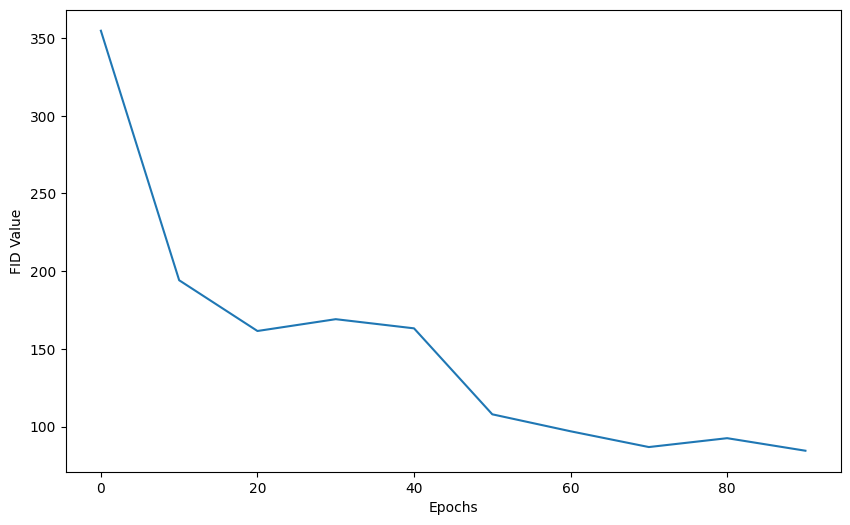

In [ ]:
def plot_fid(fid_values,epoch=20):
  epoch_list=[]
  for i in range(epoch):
    if i%10==0:
      epoch_list.append(i)
  #epoch_list = [i if i+1%10==0 else continue for i in range(epoch)]
  ax = plt.figure(figsize=(10,6))
  #gs = gridspec.GridSpec(2, 2)
  plot = plt.plot(epoch_list,fid_values)
  #ax = fig.add_subplot()
  #ax.plot(fid_values,label="FID Values",)
  plt.ylabel('FID Value')
  plt.xlabel('Epochs')
  plt.savefig("Fid_Plot_Gan_Final")

  return plot
plot_fid(FID_epoch,epoch=100)

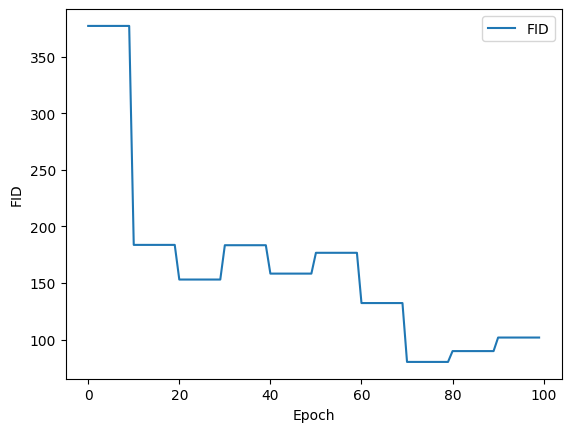

In [ ]:
#import pandas as pd
#epochs=[i for i in range(len(d_loss_epoch))]
#FID_frame = pd.DataFrame({"FID":FID_epoch}) #Epoch":epochs
#d_loss_epoch, g_loss_epoch
#FID_frame.plot(xlabel="Epoch",ylabel="FID")
#pyplot.savefig("FID_gan")

## MODEL SAVE AND GENERATOR

In [ ]:
#import pickle
#pickle.dump(model, open('model_100.pkl', 'wb'))


In [ ]:
#pickled_model = pickle.load(open('model_100.pkl', 'rb'))

In [ ]:
import pickle
pickle.dump(g_model, open('Gan_Final.pkl', 'wb'))

In [ ]:
pickled_model = pickle.load(open('Wasser.pkl', 'rb'))

In [ ]:
#filename = 'generator_model.h5'
#g_model.save(filename)

In [ ]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
 # generate points in the latent space
 x_input = randn(latent_dim * n_samples)
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n_samples, latent_dim)
 return x_input
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
  # plot images
  for i in range(n * n):
  # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.savefig("Generated Images_100_wasser")
    pyplot.show()

In [ ]:
import matplotlib.pyplot as plt
def save_plot_2(examples, n):

  for i in range(n):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(examples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    plt.savefig("Generated_images_wasser_GAN_Final")

1/1 [==============================] - 0s 29ms/step


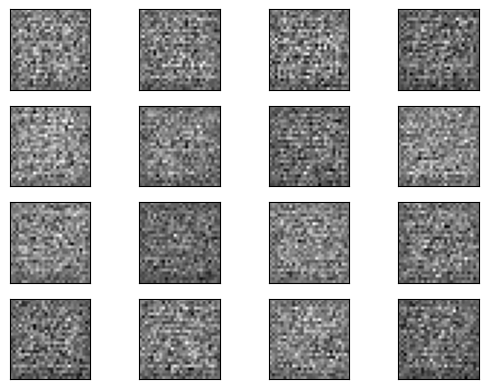

In [ ]:
#pickled_model = pickle.load(open('_generator_model_GAN.pkl', 'rb'))
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = pickled_model.predict(latent_points)
# plot the result
save_plot_2(X,16)

1/1 [==============================] - 0s 126ms/step


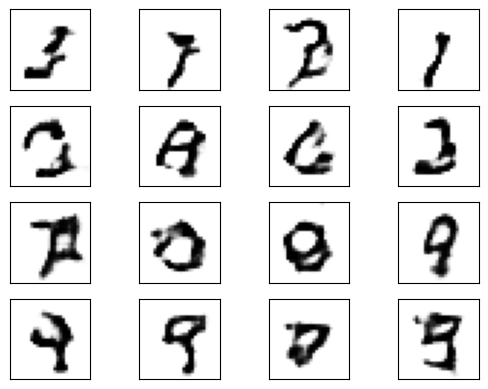

### FID ON GAN

1/1 [==============================] - 0s 30ms/step


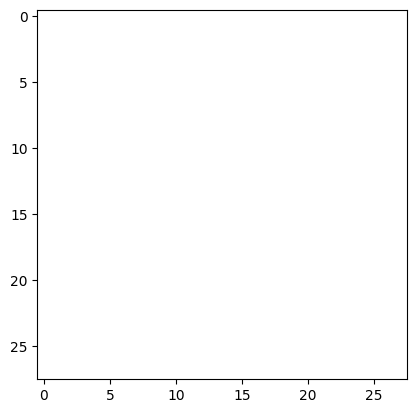